In [56]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

## Downscaling for TRMM 3h in Veneto region - Automatic

In [57]:
name, yy_s, yy_e = 'Coast Level', 1998, 2016
# name, yy_s, yy_e = 'Low Level', 1998, 2016
# name, yy_s, yy_e = 'Medium Level', 1998, 2016
# name, yy_s, yy_e = 'High Level', 2001, 2022

maxmiss = 80

print(f'Station   : {name}')
print(f'Start year: {yy_s}')
print(f'End year  : {yy_e}')

Station   : Coast Level
Start year: 1998
End year  : 2016


In [58]:
Veneto = gpd.read_file(os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson'))

## Haversine distance

In [91]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

def find_nearest_pixel(lon2d, lat2d, lon_c, lat_c):
    # Calculate the Euclidean distance between the rain gauge and each satellite pixel
    distance = np.sqrt((lon2d - lon_c)**2 + (lat2d - lat_c)**2)
    
    # Find the index of the minimum distance (nearest pixel)
    min_idx = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
    
    # Return the nearest pixel's indices and the corresponding latitude and longitude
    nearest_lat = lat2d[min_idx]
    nearest_lon = lon2d[min_idx]
    
    return min_idx, nearest_lat, nearest_lon

## LOAD TRMM DATA

In [78]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','TRMM','3_hour',f'TRMM_Veneto_3h_1998_01_01_2016_12_31.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

# DATES = DATA['time'][:]
time_vector = DATA['time'].data

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 99MB
Dimensions:  (time: 55520, lat: 13, lon: 17)
Coordinates:
  * time     (time) datetime64[ns] 444kB 1998-01-01 ... 2016-12-31T21:00:00
  * lat      (lat) float32 52B 43.88 44.12 44.38 44.62 ... 46.38 46.62 46.88
  * lon      (lon) float32 68B 10.12 10.38 10.62 10.88 ... 13.62 13.88 14.12
Data variables:
    PRE      (time, lat, lon) float64 98MB 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes:
    description:  TRMM TMPA 3 hour data for Veneto region

In [79]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Load Raingauges

In [65]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])

print(f'Original OBS S_time: {CL_RAIN['dataora'].values[0]}')
print(f'Original OBS E_time: {CL_RAIN['dataora'].values[len(CL_RAIN)-1]}')

CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year

CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
CL_RAIN.loc[CL_RAIN['valore'] > 200, 'valore'] = np.nan

CL_RAIN.set_index('dataora', inplace=True)

print()
print(f'New OBS S_time     : {CL_RAIN.index[0]}')
print(f'New OBS E_time     : {CL_RAIN.index[len(CL_RAIN)-1]}')

Coast Level station
Original OBS S_time: 1987-10-11T00:30:00.000000000
Original OBS E_time: 2017-11-30T11:00:00.000000000

New OBS S_time     : 1998-01-01 00:00:00
New OBS E_time     : 2016-12-31 23:30:00


## Convert OBS serie to daily acumm

In [66]:
OBS_daily = CL_RAIN['valore'].resample('D').sum()
OBS_NEW = pd.DataFrame({'TIME':OBS_daily.index, 'PRCP':OBS_daily.values})

## Create a manual time vector

In [67]:
TIME_REF = pd.date_range(start=f'{yy_s}-01-01', end=f'{yy_e}-12-31', freq='d')
TIME_PD = pd.DataFrame({'TIME':TIME_REF})

In [68]:
len(OBS_daily), len(TIME_PD)

(6940, 6940)

## Verify the OBS and TRMM times

In [69]:
if len(OBS_daily) < len(TIME_REF):
    print('ERROR: OBS time is not complete. Verify data')
    OBS_NEW = pd.merge(OBS_NEW, TIME_PD, on='TIME', how='right')
elif len(OBS_daily) > len(TIME_REF):
    print('ERROR: OBS time has many times. Verify data')

## Convert OBS serie to xarray and Weibul parameters

In [70]:
OBS_xr = xr.DataArray(OBS_NEW['PRCP'].values,  coords={'time':OBS_NEW['TIME'].values}, dims=('time'))
NCW_OBS, YEARS_OBS = down.fit_yearly_weibull(OBS_xr, thresh=1, maxmiss=maxmiss)

## Obtain the close TRMM pixel

In [71]:
RAIN_lat = CL_INFO['Lat'].values[0]
RAIN_lon = CL_INFO['Lon'].values[0]

In [97]:
# distances = haversine(lat2d, lon2d, RAIN_lat, RAIN_lon)
# min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

nearest_pixel, nearest_lat, nearest_lon = find_nearest_pixel(lon2d, lat2d, RAIN_lon, RAIN_lat)

clat = lats[nearest_pixel[0]]
clon = lons[nearest_pixel[1]]

TRMM_ML = dset[:,nearest_pixel[0],nearest_pixel[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {RAIN_lat}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {RAIN_lon}')

Nearest IMERG lat: 45.125
Station lat       : 45.00466666

Nearest IMERG lon: 12.125
Station lon       : 12.24819444


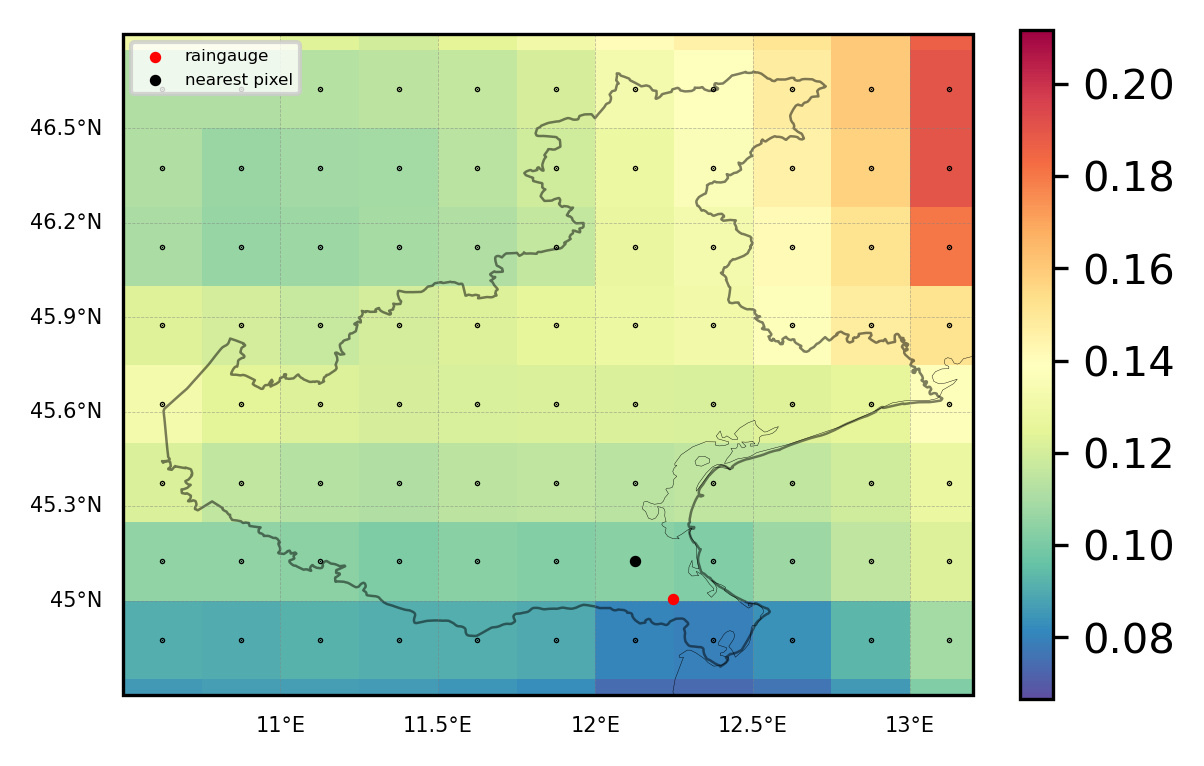

In [152]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(dset,axis=0),cmap=cmap)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')
ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=3, c='r', zorder=10, label='raingauge')
ax1.scatter(clon, clat, s=3, c='k', zorder=10, label='nearest pixel')

ax1.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

plt.colorbar(a1, fraction=0.036)

## Convert TRMM serie to xarray and Weibull parameters

In [99]:
TRMM_ML_xr = xr.DataArray(TRMM_ML,  coords={'time':time_vector}, dims=('time'))
TRMM_ML_xr = TRMM_ML_xr.resample(time ='1D').sum(dim='time', skipna=False)
NCW_TRMM, YEARS_TRMM = down.fit_yearly_weibull(TRMM_ML_xr, thresh=1, maxmiss=maxmiss)

In [100]:
bnds1 = np.where(~np.isnan(TRMM_ML_xr.data))[0]
IMERG_clear = TRMM_ML_xr.data[bnds1]
OBS_clear = OBS_xr.data[bnds1]

bnds2 = np.where(~np.isnan(OBS_clear))[0]
IMERG_clear = IMERG_clear[bnds2]
OBS_clear = OBS_clear[bnds2]

corr, _ = stats.spearmanr(IMERG_clear, OBS_clear)
corr = np.round(corr,2)
print(f'Daily correlation: {corr}')

Daily correlation: 0.48


Text(1.0, 1.0, 'Correlation: 0.48')

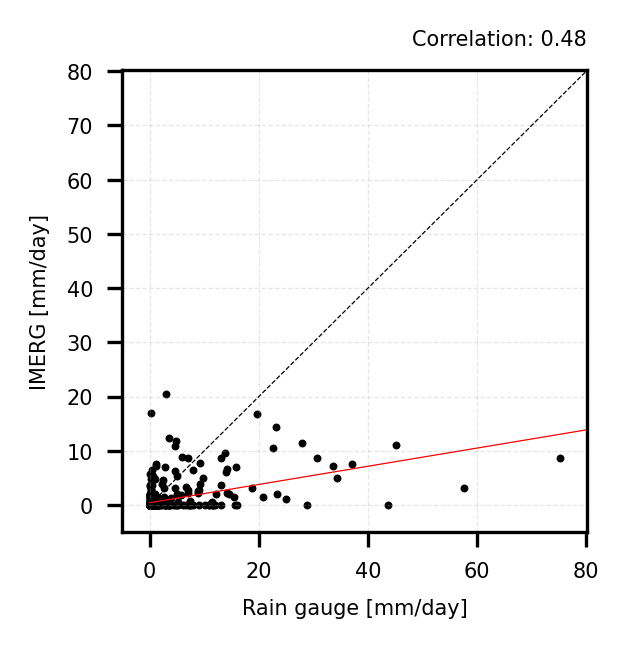

In [101]:
fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

xx = np.arange(len(IMERG_clear))
slope, intercept, _, _, _ = stats.linregress(OBS_clear, IMERG_clear)
max_limit = np.nanmax([np.nanmax(IMERG_clear), np.nanmax(OBS_clear)])

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_clear, IMERG_clear, s=0.8, color='k')

ax1.plot(xx,xx, linewidth=0.3, color='k', linestyle='--')
ax1.plot(xx,xx*slope+intercept, linewidth=0.3, color='r', linestyle='-')

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylabel('IMERG [mm/day]', fontsize=5)
ax1.set_xlabel('Rain gauge [mm/day]', fontsize=5)

ax1.set_xlim(-5, max_limit + 5)
ax1.set_ylim(-5, max_limit + 5)
ax1.grid(linewidth=0.3, linestyle='--', alpha=0.3)

ax1.set_title(f'Correlation: {corr}', fontsize=5, loc='right')

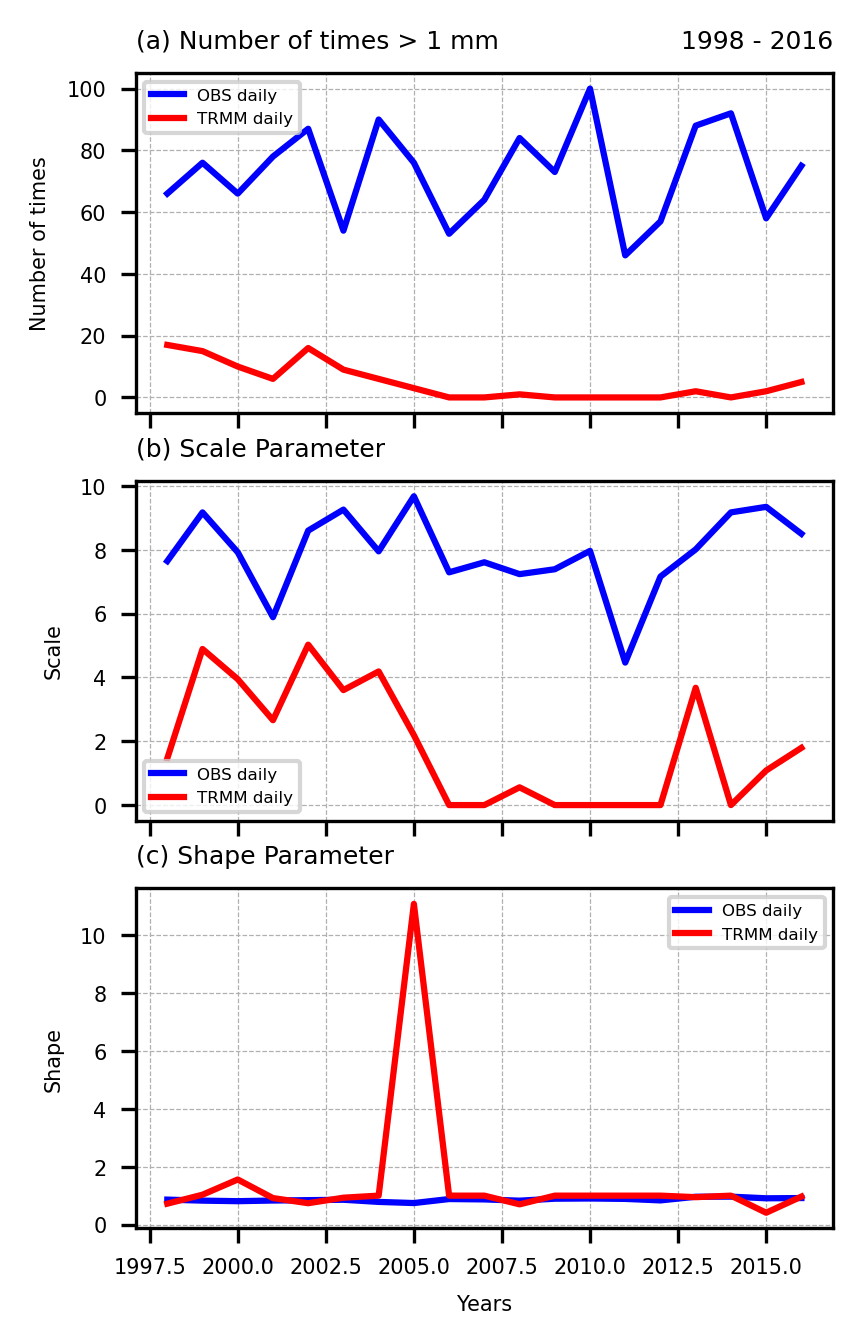

In [102]:
fig = plt.figure(figsize=(3,5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,0], c='b', label=f'OBS daily')
ax1.plot(YEARS_TRMM, NCW_TRMM[:,0], c='r', label=f'TRMM daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times > 1 mm',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_ylabel('Number of times', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,1], c='b', label=f'OBS daily')
ax1.plot(YEARS_TRMM, NCW_TRMM[:,1], c='r', label=f'TRMM daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,2], c='b', label=f'OBS daily')
ax1.plot(YEARS_TRMM, NCW_TRMM[:,2], c='r', label=f'TRMM daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

In [103]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3

Tr = np.array([5, 10, 20, 50, 80, 100])
Fi = 1-1/Tr
nyears = len(Tr)

npix = 3
buffer = 0.5*npix*dx

In [104]:
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':time_vector}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [105]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

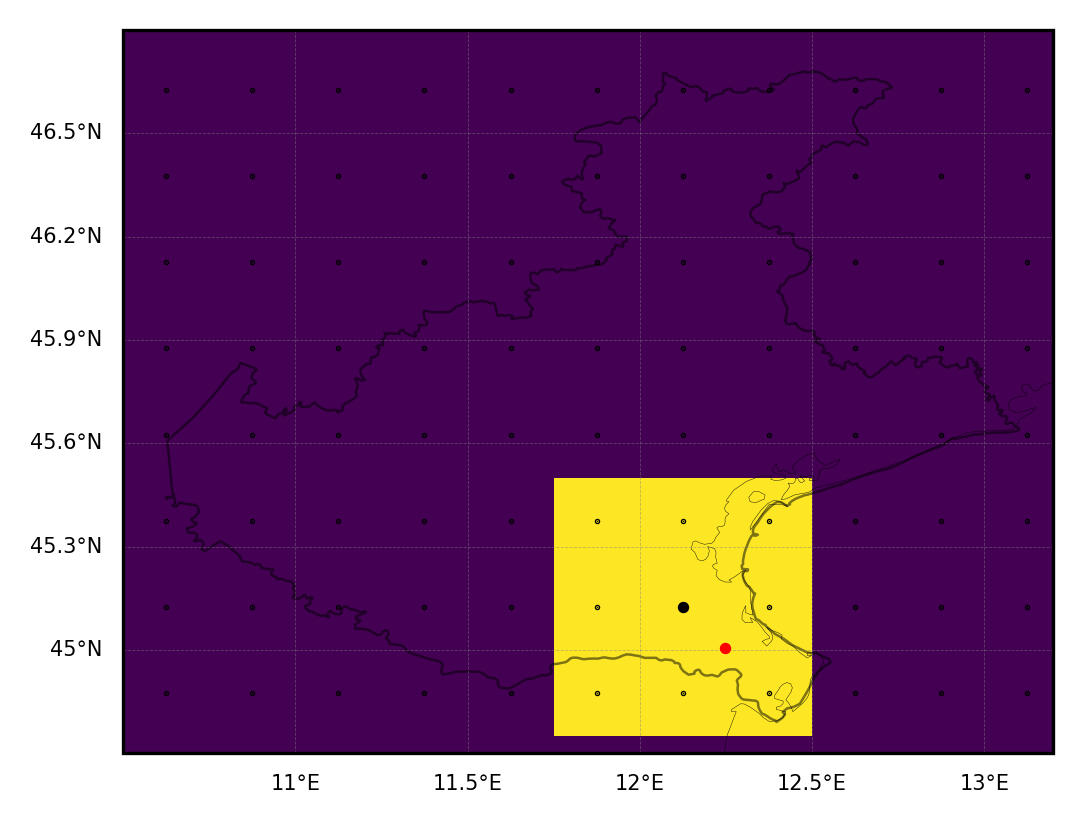

In [106]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, bcond)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')

ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=3, c='r', zorder=10)
ax1.scatter(clon, clat, s=3, c='k', zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [107]:
box_3h = xrs.where(bcond, drop = True).load()
# box_3h = box_3h.resample(time ='D').sum(dim='time', skipna=False)
box_3h.shape

(3, 3, 55520)

In [115]:
tscale = 24

L0=0.0001
dt = 3
plot = True

In [111]:
res = {} # initialize dictionary for storing results
xdata = box_3h.where(box_3h >= -0.001) # set negative values to np.nan if any
xdaily0 = xdata.resample(time ='{}h'.format(tscale)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')
lons = xdata.lon.values
lats = xdata.lat.values
nlon = np.size(lons)
nlat = np.size(lats)
dx = np.abs(lons[1] - lons[0])

In [112]:
if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
    # otherwise us the one provided by the
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

In [113]:
L1 = down.area_lat_long(clat, clon, dx, dx)[0] # in Km
# get the pixel closer to the center as central pixel:
# get the time series for the central pixel
tsc = xdaily.loc[dict(lat = clat, lon = clon)]

In [114]:
# c_excesses = np.maximum(tsc.values-thresh, 0.0)
c_excesses = tsc.values[tsc.values > thresh] - thresh
NCW = down.wei_fit(c_excesses)
pws = NCW[0]/xdaily.shape[2]
Ns = int(np.floor(pws*365.25)) #Ns = np.int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]

In [116]:
# Taylor Hypothesis for downscaling intermittency
print('Downscaling Intermittency')
taylor = down.downscale_pwet(xdata, thresh=thresh, dt=dt, L1=L1,
                target_x=L0, target_t=tscale,
                origin_x=L1, origin_t=tscale, ninterp=1000, plot=plot)

Downscaling Intermittency


In [117]:
print('Downscaling the correlation')
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

Downscaling the correlation


In [119]:
# Correlation downscaling
print('Computing the correlation')
rcorr = down.grid_corr(xdaily, plot=plot, thresh=thresh)
gam_s = down.vrf(L1, L0, (rcorr['{}_s'.format(parnames[0])],
                        rcorr['{}_s'.format(parnames[1])]), acf=acf)

Computing the correlation


In [120]:
dcorr =  down.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
                use_ave=True, opt_method=opt_method, toll=toll,
                plot=plot)

differential_evolution step 1: f(x)= 0.008477194856073907
differential_evolution step 2: f(x)= 0.008477194856073907
differential_evolution step 3: f(x)= 0.008477194856073907
differential_evolution step 4: f(x)= 0.0035795944580585604
differential_evolution step 5: f(x)= 0.0035795944580585604
differential_evolution step 6: f(x)= 0.003239051054692979
Polishing solution with 'L-BFGS-B'
integration domain is zero


In [121]:
# downscaling the Weibull pdf
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])

Downscaling pdf - global Weibull parameters


In [122]:
Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, taylor['beta'], par_acf, acf=acf)

In [136]:
maxmiss = 300

In [137]:
print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=maxmiss)
NYd, CYd, WYd, _, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, taylor['beta'], par_acf, acf=acf)


Downscaling pdf - yearly Weibull parameters


In [138]:
res['NYs'] = NCWy[:,0] # yearly Weibull parameters
res['CYs'] = NCWy[:,1] # yearly Weibull parameters
res['WYs'] = NCWy[:,2] # yearly Weibull parameters
res['NYd'] = NYd # Nd, Cd, Wd (downscaled parameters)
res['CYd'] = CYd # Nd, Cd, Wd (downscaled parameters)
res['WYd'] = WYd # Nd, Cd, Wd (downscaled parameters)

In [140]:
Fi = 1-1/Tr
res['Tr'] = Tr
# x0 = 150.0
x0 = 9.0*np.mean(CYd)
res['mev_d'] = down.mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability
res['mev_s'] = down.mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability

res['YEARS'] = YEARSy # Add for Arturo

res['gam_d'] = gam_d # variance reduction function downscale
res['gam_s'] = gam_s # variance reduction factor
res['beta'] = taylor['beta'] # ratio between pwet at the grid cell scale () to pwet at the target subgrid scale ()
res['Nd'] = Nd # Nd, Cd, Wd (downscaled parameters)
res['Cd'] = Cd # Nd, Cd, Wd (downscaled parameters)
res['Wd'] = Wd # Nd, Cd, Wd (downscaled parameters)
res['Ns'] = Ns # global Weibull parameters
res['Cs'] = Cs # global Weibull parameters
res['Ws'] = Ws # global Weibull parameters
res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] =        dcorr['success']
res['corr_down_funval'] =         dcorr['funval']
res['w_down_funval'] = fval_w[0] # function value at the end of numerical minimization
res['thresh'] = thresh # threshold used in the analysis
res['clat'] = clat
res['clon'] = clon
if plot:
    res['corr_plot'] = dcorr['fig']
    res['Taylor_contour'] = taylor['contour']

mevd_quant:: ERROR - fsolve does not work -  change x0


In [144]:
res['beta']

1.023981393407806

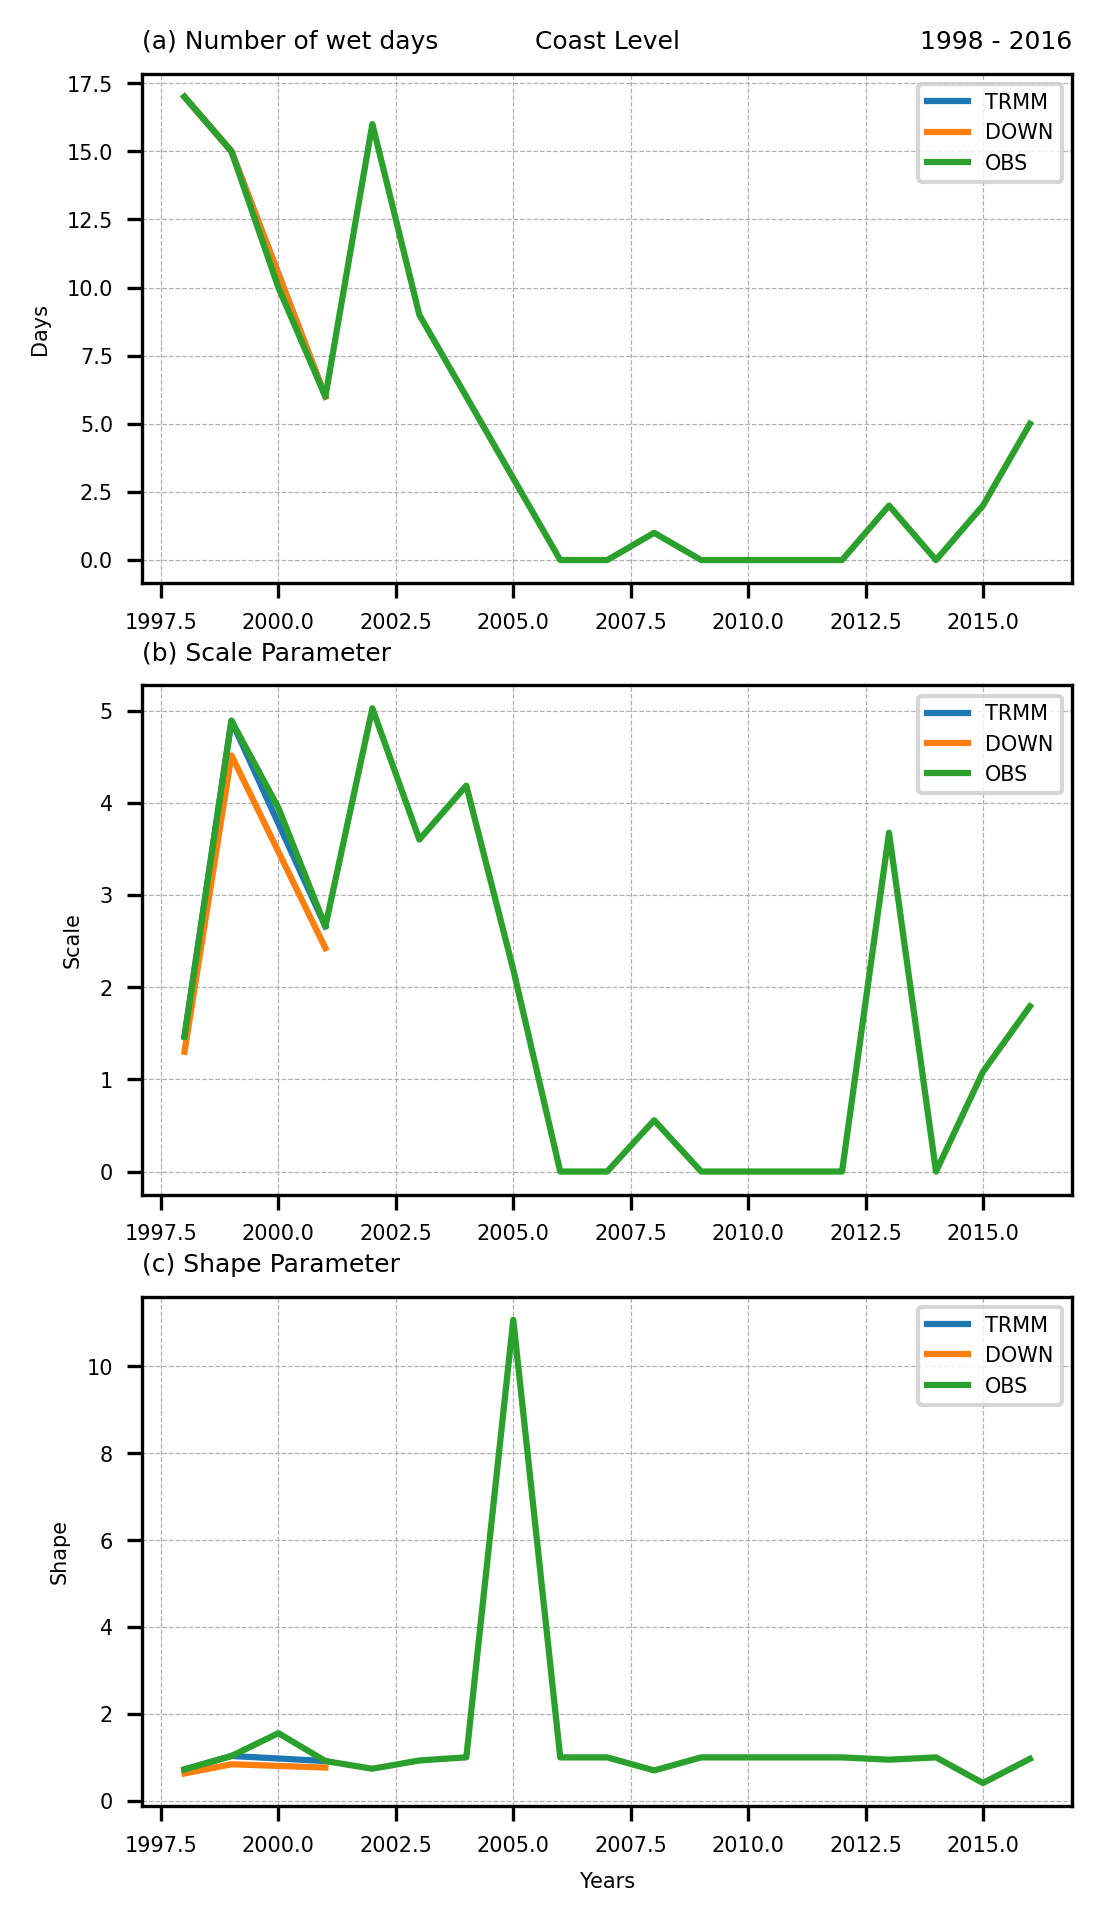

In [153]:
fig = plt.figure(figsize=(4,7.5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARSy, res['NYs'], label=f'TRMM')
ax1.plot(YEARSy, res['NYd'], label=f'DOWN')
ax1.plot(YEARS_TRMM, NCW_TRMM[:,0], label='OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of wet days',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_title(f'{name}',loc='center',fontsize=6)
ax1.set_ylabel('Days', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARSy, res['CYs'], label=f'TRMM')
ax1.plot(YEARSy, res['CYd'], label=f'DOWN')
ax1.plot(YEARS_TRMM, NCW_TRMM[:,1], label='OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARSy, res['WYs'], label=f'TRMM')
ax1.plot(YEARSy, res['WYd'], label=f'DOWN')
ax1.plot(YEARS_TRMM, NCW_TRMM[:,2], label='OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)